Test passed: The second-quantized state correctly encodes the real and imaginary parts.


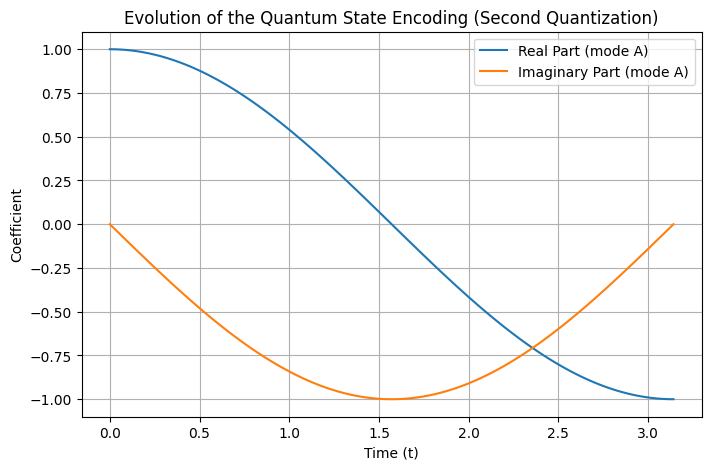

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import tensor, destroy, qeye, fock

def complex_amplitude_encoding_sq(a, b, t=np.pi/2):
    r"""
    Second-quantized encoding of two real numbers (a, b) into a quantum state.
    Here, we use a two-mode Fock space where:
      - |1,0> means one particle in mode A (our computational basis state)
      - |0,1> means one particle in mode B.
      
    The encoding is achieved by defining:
      v0 = (a + i b)/sqrt(a^2 + b^2)
      v1 = sqrt(1 - |v0|^2)
      
    Then we construct the operator:
      a_v^\dagger = v0 * a^\dagger + v1 * b^\dagger,
    so that on the single-particle subspace the projector H = a_v^\dagger a_v = |v><v|.
    
    Args:
        a (float): Real part to encode.
        b (float): Imaginary part to encode.
        t (float): Evolution time parameter.
        
    Returns:
        evolved_state: Qobj representing the evolved state.
        H: The Hamiltonian operator.
    """
    norm = np.sqrt(a**2 + b**2)
    if norm == 0:
        raise ValueError("Both numbers cannot be zero.")
    target_state = (a + 1j * b) / norm  # v0
    v0 = target_state
    v1 = np.sqrt(1 - np.abs(target_state)**2)
    
    # Build two-mode Fock space operators.
    a_op = tensor(destroy(2), qeye(2))  # annihilation operator for mode A
    b_op = tensor(qeye(2), destroy(2))  # annihilation operator for mode B
    
    # Their Hermitian conjugates (creation operators)
    a_dag = a_op.dag()
    b_dag = b_op.dag()
    
    # Define the encoded creation operator:
    #   a_v^\dagger = v0 * a_dag + v1 * b_dag
    av_dag = v0 * a_dag + v1 * b_dag
    av = av_dag.dag()
    
    # On the single-particle subspace, H = a_v^\dagger a_v acts as the projector |v><v|
    H = av_dag * av
    
    # Define the initial state as one particle in mode A, i.e. |1,0>
    initial_state = tensor(fock(2, 1), fock(2, 0))
    
    # Unitary evolution operator: U = exp(-i t H)
    U = (-1j * t * H).expm()
    
    evolved_state = U * initial_state
    return evolved_state, H

def plot_evolution_sq(a, b, timesteps=100):
    r"""
    Plots the time evolution of the amplitude in mode A (i.e. the coefficient
    corresponding to |1,0>) under the second-quantized encoding.
    
    Args:
        a (float): Real part to encode.
        b (float): Imaginary part to encode.
        timesteps (int): Number of time steps for visualization.
    """
    times = np.linspace(0, np.pi, timesteps)
    real_parts = []
    imag_parts = []
    
    # Note: In our two-mode representation, the ordering of the basis is
    # |0,0>, |0,1>, |1,0>, |1,1>.
    # The state |1,0> has its nonzero entry at index 2.
    for t in times:
        psi, _ = complex_amplitude_encoding_sq(a, b, t)
        coeff = psi.full()[2, 0]
        real_parts.append(np.real(coeff))
        imag_parts.append(np.imag(coeff))
    
    plt.figure(figsize=(8, 5))
    plt.plot(times, real_parts, label='Real Part (mode A)')
    plt.plot(times, imag_parts, label='Imaginary Part (mode A)')
    plt.xlabel("Time (t)")
    plt.ylabel("Coefficient")
    plt.title("Evolution of the Quantum State Encoding (Second Quantization)")
    plt.legend()
    plt.grid(True)
    plt.show()

def test_complex_amplitude_encoding_sq():
    r"""
    Tests that the second-quantized encoding produces the expected state.
    In the single-particle subspace, the encoded state should be:
    
        |v> = v0 |1,0> + v1 |0,1>,
        
    where v0 and v1 are as defined above.
    """
    a_val, b_val = 0.6, 0.8
    psi, _ = complex_amplitude_encoding_sq(a_val, b_val)
    
    norm = np.sqrt(a_val**2 + b_val**2)
    v0 = (a_val + 1j * b_val) / norm
    v1 = np.sqrt(1 - np.abs(v0)**2)
    
    # Construct the expected state |v> = v0 |1,0> + v1 |0,1>
    state_10 = tensor(fock(2, 1), fock(2, 0))
    state_01 = tensor(fock(2, 0), fock(2, 1))
    expected_state = v0 * state_10 + v1 * state_01
    
    # Compute the fidelity using the overlap method
    fidelity = abs(expected_state.overlap(psi))**2
    assert np.isclose(fidelity, 1.0, atol=1e-6), "Encoding failed! Fidelity is not close to 1."
    print("Test passed: The second-quantized state correctly encodes the real and imaginary parts.")

# Run the test function and plot the evolution.
test_complex_amplitude_encoding_sq()
plot_evolution_sq(0.6, 0.8)
